Dataset : https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database

# Content-based Movie Recommendation :

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from wordcloud import WordCloud

In [60]:
ratings = pd.read_csv('/content/drive/MyDrive/NEU/DMT/project/rating.csv')
anime = pd.read_csv('/content/drive/MyDrive/NEU/DMT/project/anime.csv')

**Data preprocessing:**

In [61]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [62]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [63]:
# observing the dataset as a whole

# We can see that the minimum rating score is 1.67 and the maximum rating score 
# is 10. The minimum members is 5 and the maximum is 1,013,917.

anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [64]:
# There is no duplicated data that need to be cleaned.

duplicated_data = anime[anime.duplicated()]
print(duplicated_data)

Empty DataFrame
Columns: [anime_id, name, genre, type, episodes, rating, members]
Index: []


### Taking care of missing values

In [65]:
anime.loc[anime['rating'].isnull(), 'rating'] = 0.0
anime['rating'].isnull().any()

False

In [66]:
anime.dropna(subset=['type'], inplace=True)

In [67]:
anime.dropna(subset=['episodes'], inplace=True)

In [68]:
# checning is all the animes with missing episodes and types are dropped
missing = anime.loc[(anime['episodes']=="Unknown") & (anime['type'].isnull())].copy()
missing.shape

(0, 7)

### Taking care of genres which are missing and replacing them with 'Unknown' instead

### Cleaning genres

Listing the top 15 rated animes

In [69]:
anime.groupby('name')['rating'].mean().sort_values(ascending=False).head(15)

name
Taka no Tsume 8: Yoshida-kun no X-Files                      10.00
Spoon-hime no Swing Kitchen                                   9.60
Mogura no Motoro                                              9.50
Kimi no Na wa.                                                9.37
Kahei no Umi                                                  9.33
Fullmetal Alchemist: Brotherhood                              9.26
Yakusoku: Africa Mizu to Midori                               9.25
Gintama°                                                      9.25
Steins;Gate                                                   9.17
Gintama&#039;                                                 9.16
Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou     9.15
Hunter x Hunter (2011)                                        9.13
Ginga Eiyuu Densetsu                                          9.11
Gintama&#039;: Enchousen                                      9.11
Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare      

In [70]:
anime.groupby('name')['rating'].count().sort_values(ascending=False).head(15)

name
Saru Kani Gassen                                2
Shi Wan Ge Leng Xiaohua                         2
&quot;0&quot;                                   1
Otoshidama                                      1
Otome Nadeshiko Koi Techou                      1
Otome Youkai Zakuro                             1
Otome Youkai Zakuro Picture Drama               1
Otome wa Boku ni Koishiteru                     1
Otome wa Boku ni Koishiteru Special             1
Otome wa Boku ni Koishiteru: Futari no Elder    1
Otona Joshi no Anime Time                       1
Otona no Ikkyuu-san                             1
Otsuki-sama to Oujo                             1
Otome Hime                                      1
Ou Dorobou Jing                                 1
Name: rating, dtype: int64

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [72]:
anime.loc[anime['rating'].isnull(), 'rating'] = 0.0
anime['rating'].isnull().any()

False

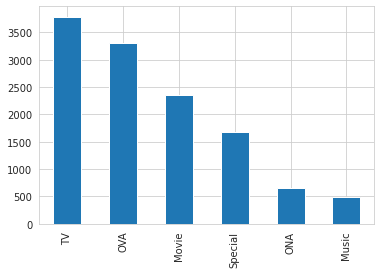

In [73]:
anime['type'].value_counts().plot.bar()

## RATING BASED

### Printing the top animes based on weighted ratings

Sorting the recommendation based on their respective weighted rating

In [74]:
# Pick Data that have more than 9,437 members
quantile = 0.75
min_vote = anime['members'].quantile(quantile)
print(min_vote)

9453.0


In [75]:
ratings_mean = anime['rating'].mean()    # Mean of the ratings across the dataset

selected_anime = anime.copy().loc[anime['members'] > min_vote]

This is the weighted rating calculation.

$W R=\left(\frac{v}{v+m} \times R\right)+\left(\frac{m}{v+m} \times C\right)$

#### v : number of votes for the anime
#### m : minimum votes required to be listed in the chart
#### R : average rating of the anime
#### C : mean vote across the whole report

In [76]:
def weighted_rating(x,C= ratings_mean, m= min_vote):
    v = x['members']
    R = x['rating']
    return (v/(v+m)*R)+(m/(v+m)*C)

selected_anime['score'] = weighted_rating(selected_anime)
selected_anime.sort_values('score', ascending =False)
selected_anime.head(15)

,anime_id,name,genre,type,episodes,rating,members,score
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,9.234818
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,9.225933
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,9.029614
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,9.131189
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,8.995650
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351,8.893982
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855,9.069972
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679,8.822182
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534,8.784742
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109,8.823549


In [77]:
selected_anime.drop(['anime_id', 'rating', 'members', 'episodes'], axis=1, inplace=True)
selected_anime.head()

,name,genre,type,score
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,9.234818
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,9.225933
2,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.029614
3,Steins;Gate,"Sci-Fi, Thriller",TV,9.131189
4,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,8.995650


In [78]:
selected_anime['genre'] = selected_anime['genre'].fillna('')

##GENRE BASED :

##Using TFIDF and CountVectorizer

In [79]:
tf_idf = TfidfVectorizer(lowercase=True, stop_words = 'english')
tf_idf_matrix = tf_idf.fit_transform(selected_anime['genre'])
tf_idf_matrix.shape

(3067, 46)

In [80]:
count_vec = CountVectorizer(stop_words = 'english')
count_matrix = count_vec.fit_transform(selected_anime['genre'])
count_matrix.shape

(3067, 46)

In [81]:
indices = pd.Series(selected_anime.index, index=selected_anime['name'])
indices = indices.drop_duplicates()

In [82]:
def recommendations (name, cosine_sim, method):
    print("Anime recommendations for " , name , "with" , method , ": \n")
    sim_scores = list(enumerate(cosine_sim[indices[name]]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    anime_indices = [i[0] for i in sim_scores]
    result = selected_anime[['name', 'genre', 'score']].iloc[anime_indices]
    return result

In [125]:
#for dropdown
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

#Create a dropdown menu for the item
def f(x):
  display(x)
  return x

C1 = selected_anime['name']
P1 = interactive(f, x = widgets.Dropdown(options=C1, value='Naruto' ,description='Anime Title:',disabled=False))

print("Select an Anime: ")
display(P1)

Select an Anime: 


interactive(children=(Dropdown(description='Anime Title:', index=770, options=('Kimi no Na wa.', 'Fullmetal Al…

In [133]:
print(selected_anime.loc[selected_anime['name'] == P1.result, 'genre'])

869    Comedy, Shounen, Supernatural
Name: genre, dtype: object


In [134]:
lin_ker_tfidf = linear_kernel(tf_idf_matrix, tf_idf_matrix)
recommendations(P1.result , lin_ker_tfidf , method = "TFIDF using Linear kernel")

Anime recommendations for  Inu x Boku SS Special with TFIDF using Linear kernel : 



,name,genre,score
163,One Piece Film: Z,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.166204
212,One Piece Film: Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.662456
960,One Piece: Heart of Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.263478
2472,Digimon Frontier,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.150939
1991,Tsubasa Chronicle: Tori Kago no Kuni no Himegimi,"Action, Adventure, Drama, Fantasy, Shounen",7.165277
1159,Digimon Tamers,"Adventure, Comedy, Drama, Fantasy, Shounen",7.533092
3017,Digimon Savers,"Adventure, Comedy, Drama, Fantasy, Shounen",6.962483
3329,Digimon Frontier: Ornismon Fukkatsu!!,"Adventure, Comedy, Drama, Fantasy, Shounen",6.731341
4404,Juubee-chan: Lovely Gantai no Himitsu,"Action, Adventure, Comedy, Drama, Shounen",6.565902
989,Toriko,"Action, Adventure, Comedy, Fantasy, Shounen",7.537784


In [135]:
cosine_sim_tfidf = cosine_similarity(tf_idf_matrix, tf_idf_matrix)
recommendations(P1.result, cosine_sim_tfidf , method = "TFIDF using Cosine similarity")

Anime recommendations for  Inu x Boku SS Special with TFIDF using Cosine similarity : 



,name,genre,score
163,One Piece Film: Z,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.166204
212,One Piece Film: Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.662456
960,One Piece: Heart of Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.263478
2472,Digimon Frontier,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.150939
1991,Tsubasa Chronicle: Tori Kago no Kuni no Himegimi,"Action, Adventure, Drama, Fantasy, Shounen",7.165277
1159,Digimon Tamers,"Adventure, Comedy, Drama, Fantasy, Shounen",7.533092
3017,Digimon Savers,"Adventure, Comedy, Drama, Fantasy, Shounen",6.962483
3329,Digimon Frontier: Ornismon Fukkatsu!!,"Adventure, Comedy, Drama, Fantasy, Shounen",6.731341
4404,Juubee-chan: Lovely Gantai no Himitsu,"Action, Adventure, Comedy, Drama, Shounen",6.565902
989,Toriko,"Action, Adventure, Comedy, Fantasy, Shounen",7.537784


In [136]:
cosine_sim_count = cosine_similarity(count_matrix, count_matrix)
recommendations(P1.result, cosine_sim_count , method = "Count Vectorizer using Cosine similarity")

Anime recommendations for  Inu x Boku SS Special with Count Vectorizer using Cosine similarity : 



,name,genre,score
163,One Piece Film: Z,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.166204
212,One Piece Film: Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.662456
960,One Piece: Heart of Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.263478
2472,Digimon Frontier,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.150939
989,Toriko,"Action, Adventure, Comedy, Fantasy, Shounen",7.537784
1159,Digimon Tamers,"Adventure, Comedy, Drama, Fantasy, Shounen",7.533092
1827,Naruto: Shippuuden Movie 1,"Action, Adventure, Comedy, Fantasy, Shounen",7.344468
1853,Digimon Xros Wars: Aku no Death General to Nan...,"Action, Adventure, Comedy, Fantasy, Shounen",6.966133
1868,MÄR,"Action, Adventure, Comedy, Fantasy, Shounen",7.160610
1991,Tsubasa Chronicle: Tori Kago no Kuni no Himegimi,"Action, Adventure, Drama, Fantasy, Shounen",7.165277


In [137]:
lin_ker_count = linear_kernel(count_matrix, count_matrix)
recommendations(P1.result, lin_ker_count , method = "Count Vectorizer using Linear kernel")

Anime recommendations for  Inu x Boku SS Special with Count Vectorizer using Linear kernel : 



,name,genre,score
143,One Piece Film: Strong World,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.214449
163,One Piece Film: Z,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.166204
200,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",8.299552
212,One Piece Film: Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.662456
231,One Piece: Episode of Merry - Mou Hitori no Na...,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.608722
241,One Piece: Episode of Nami - Koukaishi no Nami...,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.743037
896,One Piece: Episode of Sabo - 3 Kyoudai no Kizu...,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.154546
960,One Piece: Heart of Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.263478
1558,Fullmetal Alchemist: The Sacred Star of Milos,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",7.389912
2472,Digimon Frontier,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.150939


##**Using K-means Clustering :**

In [88]:
combined_df = pd.merge(anime,ratings,on=['anime_id','anime_id'])
combined_df = combined_df[combined_df.user_id <= 20000]
combined_df.head(10)

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1
5,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10
6,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,398,10
7,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,462,8
8,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,490,10
9,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,548,10


In [89]:
combined_df_crosstab = pd.crosstab(combined_df['user_id'], combined_df['name'])
combined_df_crosstab.head(10)

name,&quot;0&quot;,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,&quot;Eiji&quot;,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,...,lilac (bombs Jun Togawa),makemagic,s.CRY.ed,vivi,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,◯
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**PCA :**

Reduce dimensionions of data for clustering and visualization

In [90]:
pca = PCA(n_components=4)
pca.fit(combined_df_crosstab)
pca_samples = pca.transform(combined_df_crosstab)

In [91]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3
0,2.787296,-3.080319,3.517113,-1.507138
1,-2.687439,-0.502603,0.428057,0.444363
2,0.228168,-1.549976,-2.098287,-2.132925
3,-0.840410,-0.352612,0.354525,-0.653500
4,9.282068,-2.007200,2.596317,-1.029917


In [92]:
ps_clusters = pd.DataFrame(ps[[0,1,2]])

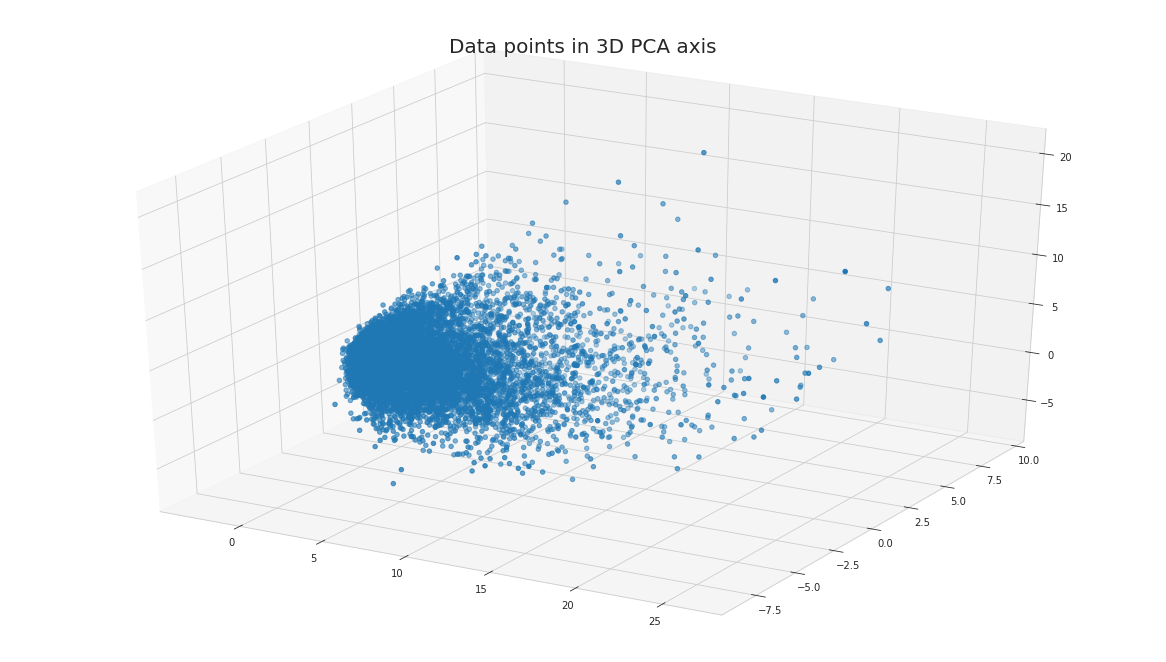

In [93]:
plt.rcParams['figure.figsize'] = (16, 9)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(ps_clusters[0], ps_clusters[2], ps_clusters[1])

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

In [94]:
scores = []
inertia_list = np.empty(8)

for i in range(2,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(ps_clusters)
    inertia_list[i] = kmeans.inertia_
    scores.append(silhouette_score(ps_clusters, kmeans.labels_))

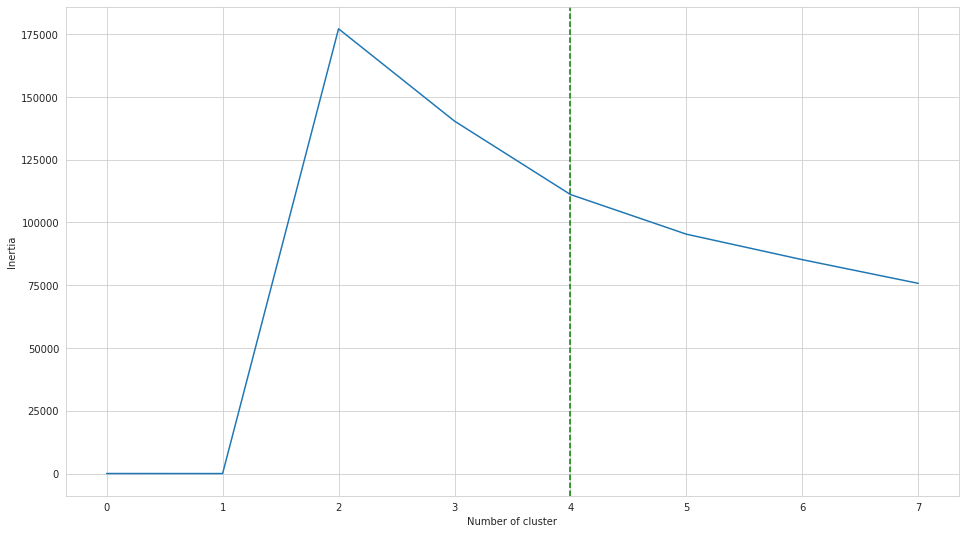

In [95]:
plt.plot(range(0,8),inertia_list)
plt.xlabel('Number of cluster')

plt.axvline(x=4, color='green', linestyle='--')
plt.ylabel('Inertia')
plt.show()

In [96]:
cls = KMeans(n_clusters=4,random_state=30).fit(ps_clusters)
centers = cls.cluster_centers_
c_preds = cls.predict(ps_clusters)

print(centers)

[[-1.73994241 -0.03865388  0.10685641]
 [ 9.48183692 -1.22558915  0.9655877 ]
 [ 2.271959   -1.32908714 -0.64867099]
 [ 2.26013304  3.73879245  0.05978608]]


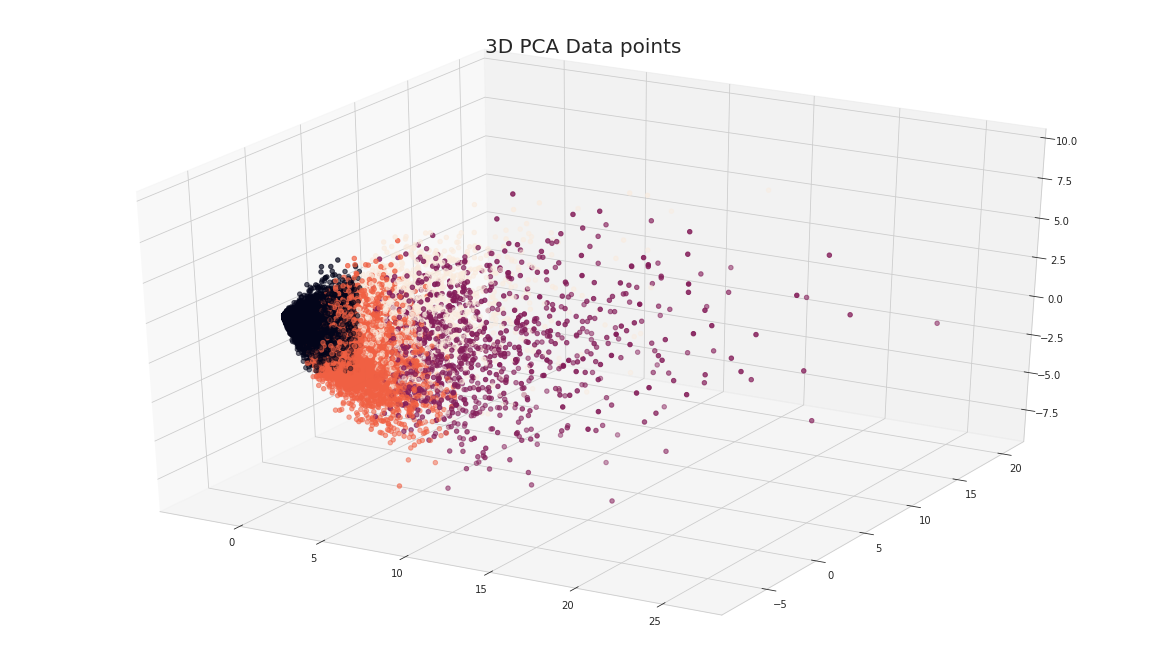

In [97]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(ps_clusters[0], ps_clusters[1], ps_clusters[2], c = c_preds)
plt.title('3D PCA Data points', fontsize=20)

plt.show()

In [98]:
combined_df_crosstab['cluster'] = c_preds

cluster_0 = combined_df_crosstab[combined_df_crosstab['cluster']==0].drop('cluster',axis=1).mean()
cluster_1 = combined_df_crosstab[combined_df_crosstab['cluster']==1].drop('cluster',axis=1).mean()
cluster_2 = combined_df_crosstab[combined_df_crosstab['cluster']==2].drop('cluster',axis=1).mean()
cluster_3 = combined_df_crosstab[combined_df_crosstab['cluster']==3].drop('cluster',axis=1).mean()

In [99]:
#Creating a list of all columns 
def info_list(animelist):
    episode_list = list()
    genre_list = list()
    member_list = list()
    rating_list= list()
    for x in anime['name']:
        if x in animelist:
            member_list.append(anime[anime['name']==x].members.values.astype(int))
            rating_list.append(anime[anime['name']==x].rating.values.astype(int))
            for y in anime[anime['name']==x].genre.values:
                 genre_list.append(y)
    return genre_list,rating_list,member_list

In [100]:
def count_word(df, ref_col, lst):
    keyword_count = dict()
    for s in lst: 
      keyword_count[s] = 0

    for item in df[ref_col].str.split(','):        
        if type(item) == float and pd.isnull(item): 
          continue        
        for s in [s for s in item if s in lst]: 
            if pd.notnull(s): keyword_count[s] += 1

    keyword_lst = []
    for k,v in keyword_count.items():
        keyword_lst.append([k,v])
    keyword_lst.sort(key = lambda x:x[1], reverse = True)
    return keyword_lst, keyword_count

In [101]:
def print_word_clouds(words,name,color):
  words_dict = dict()
  for item in words:
    words_dict[item[0]] = item[1]
  print(words_dict)
  wordcloud = WordCloud(width = 1000, height = 500 , max_words=20, max_font_size=500, background_color=color).generate_from_frequencies(words_dict)

  plt.figure(figsize=(15,8))
  plt.title(name)
  plt.imshow(wordcloud)
  plt.axis("off")
  #plt.show()


In [102]:
def avg_rating(cluster_data, cluster):
  print('\nAverage movie rating of cluster ', cluster , ' : ',  cluster_data['rating'].mean())

In [103]:
anime_list = list(cluster_0.index)
data = pd.DataFrame()
data['genre'],data['rating'],data['member'] =  info_list(anime_list)
#data['genre'],data['rating'],data['member'] =  createAnimeInfoList(animelist)

Set = set()
for i in data['genre'].str.split(',').values:
    if isinstance(i, float): 
      continue  # NaN
    Set = Set.union(i)

{'Action': 11, ' Drama': 7, ' Supernatural': 6, ' Shounen': 6, ' Fantasy': 5, ' Super Power': 4, ' Military': 4, ' Romance': 4, ' School': 4, ' Psychological': 3}


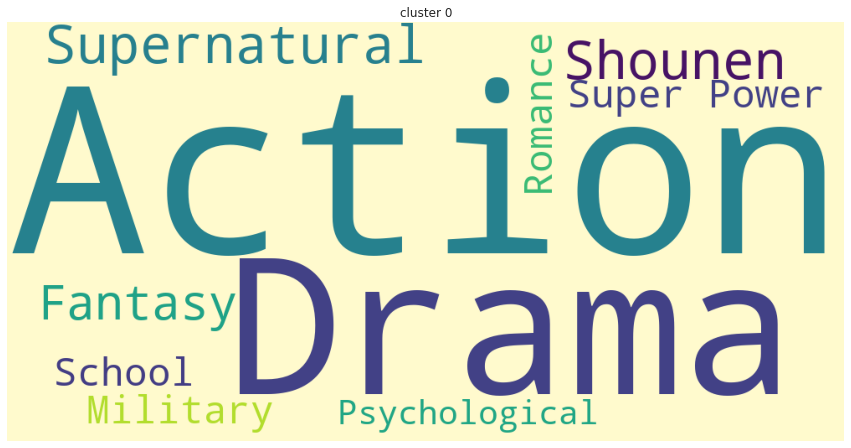

In [104]:
c0 = list(cluster_0.sort_values(ascending=False)[0:15].index)

c0_data = pd.DataFrame()
c0_data['genre'],c0_data['rating'],c0_data['member'] =  info_list(c0)
c0_data.iloc[:,1:4] = c0_data.iloc[:,1:4].astype(int)

keywords, dum = count_word(c0_data, 'genre', Set)

print_word_clouds(keywords[0:10],"cluster 0","lemonchiffon")

In [105]:
avg_rating(c0_data, "0")


Average movie rating of cluster  0  :  7.8


Cluster 1 :

{' Romance': 7, 'Action': 7, ' Supernatural': 6, ' School': 6, 'Comedy': 6, ' Slice of Life': 4, ' Drama': 4, ' Fantasy': 4, ' Ecchi': 4, ' Shounen': 3}


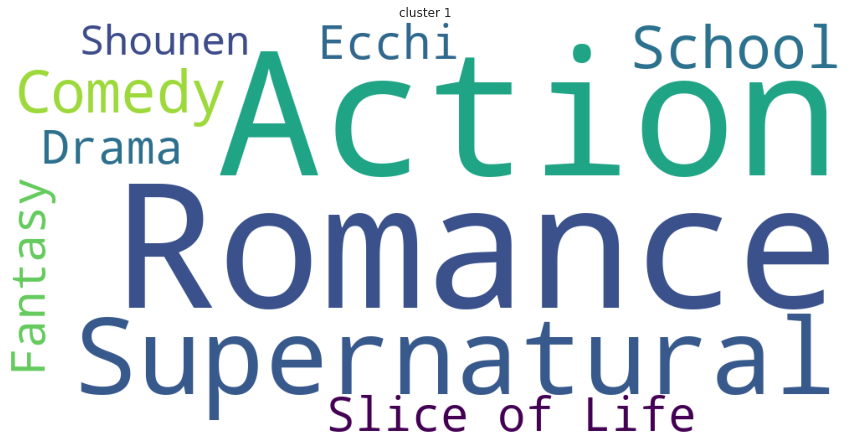

In [106]:
c1 = list(cluster_1.sort_values(ascending=False)[0:15].index)
c1_data = pd.DataFrame()
c1_data['genre'],c1_data['rating'],c1_data['member'] =  info_list(c1)
c1_data.iloc[:,1:4] = c1_data.iloc[:,1:4].astype(int)
keywords, dum = count_word(c1_data, 'genre', Set)

print_word_clouds(keywords[0:10],"cluster 1","white")

In [107]:
avg_rating(c1_data, "1")


Average movie rating of cluster  1  :  7.6


Cluster 2 :

{'Action': 10, ' Supernatural': 9, ' Fantasy': 5, ' Shounen': 5, ' Drama': 4, ' Thriller': 4, ' School': 4, ' Psychological': 3, ' Mystery': 3, ' Adventure': 3}


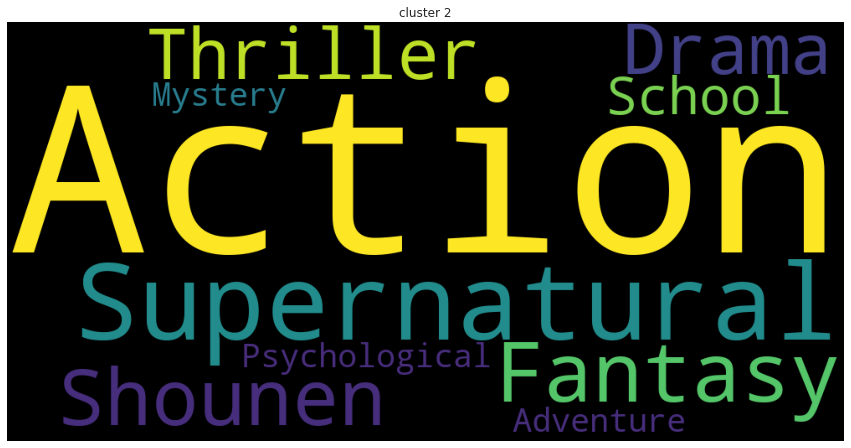

In [108]:
c2 = list(cluster_2.sort_values(ascending=False)[0:15].index)
c2_data = pd.DataFrame()
c2_data['genre'],c2_data['rating'],c2_data['member'] =  info_list(c2)
c2_data.iloc[:,1:4] = c2_data.iloc[:,1:4].astype(int)
keywords, dum = count_word(c2_data, 'genre', Set)

print_word_clouds(keywords[0:10],"cluster 2","black")

In [109]:
avg_rating(c2_data, "2")


Average movie rating of cluster  2  :  7.866666666666666


Cluster 3 :

{'Action': 11, ' Sci-Fi': 8, ' Drama': 6, ' Supernatural': 5, ' Mecha': 5, ' Military': 4, ' Comedy': 4, ' Super Power': 3, ' Psychological': 3, ' Romance': 3}


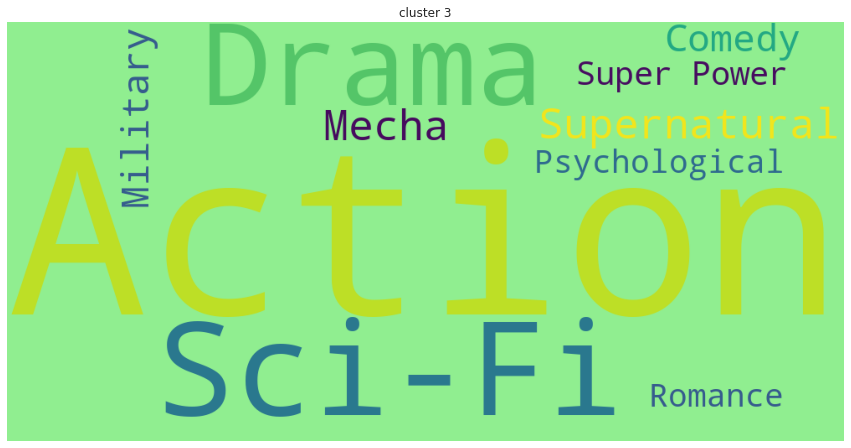

In [110]:
c3 = list(cluster_3.sort_values(ascending=False)[0:15].index)
c3_data = pd.DataFrame()
c3_data['genre'],c3_data['rating'],c3_data['member'] =  info_list(c3)
c3_data.iloc[:,1:4] = c3_data.iloc[:,1:4].astype(int)
keywords, dum = count_word(c3_data, 'genre', Set)

print_word_clouds(keywords[0:10],"cluster 3","lightgreen")

In [111]:
avg_rating(c3_data, "3")


Average movie rating of cluster  3  :  7.733333333333333
